# Tensorflow implementation of MIL for hyperspectral ToF-SIMS imaging data

Version 1.1 - February 2024

Created by Wil Gardner, Centre for Materials and Surface Science (Prof. Paul Pigram, Director), La Trobe University

If you use this method in your work please cite our paper:

[**Markedly Enhanced Analysis of Mass Spectrometry Images Using Weakly Supervised Machine Learning**](https://onlinelibrary.wiley.com/doi/10.1002/smtd.202301230)

In [ ]:
#Library imports
import os, json
from tensorflow.keras import optimizers
from scipy import io
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for visual styling

#Local imports
from sims_mil import create_mil_model
from utils import  (
    path_train_test_split, load_data_from_paths, compute_minmax, scale_data, DataGen, CosineDecayWithWarmup, row_norm
)

# Parameters

In [4]:
DATA_PATH = r'path/to/data/folder'      #Path to folder with data from binary classes in subfolders
TRAIN_SIZE = 0.8                        #Percentage of data to use to train model (1-test_size)
SEED = 42                               #Random seed
FILE_FORMAT = '.mat'                    #Format of the input data files, currently either '.mat' or '.npy'
USE_ROW_NORM = True                     #Whether to normalise data rows to their sums
INIT_LEARNING_RATE = 0.001              #Initial learning rate for cosine decay scheme
WARMUP_EPOCHS = 5                       #Number of warmup epochs for cosine decay scheme
GAMMA = 0.5                             #Information entropy regularisation parameter
EPOCHS = 50                             #Training epochs
FE_UNITS = [64, 32]                     #Units for dense layers in feature extractor MLP

# Data import and preprocessing

In [5]:
#Generate train, validation and test paths
train_paths, test_paths, train_labels, test_labels = path_train_test_split(
    path=DATA_PATH, train_size=TRAIN_SIZE, seed=SEED, file_format=FILE_FORMAT
)

In [6]:
#Load training data
print('Loading training data...')
X_train, X_train_shapes = load_data_from_paths(train_paths, file_format=FILE_FORMAT)

Loading training data...
10 of 300 images loaded.
20 of 300 images loaded.
30 of 300 images loaded.
40 of 300 images loaded.
50 of 300 images loaded.
60 of 300 images loaded.
70 of 300 images loaded.
80 of 300 images loaded.
90 of 300 images loaded.
100 of 300 images loaded.
110 of 300 images loaded.
120 of 300 images loaded.
130 of 300 images loaded.
140 of 300 images loaded.
150 of 300 images loaded.
160 of 300 images loaded.
170 of 300 images loaded.
180 of 300 images loaded.
190 of 300 images loaded.
200 of 300 images loaded.
210 of 300 images loaded.
220 of 300 images loaded.
230 of 300 images loaded.
240 of 300 images loaded.
250 of 300 images loaded.
260 of 300 images loaded.
270 of 300 images loaded.
280 of 300 images loaded.
290 of 300 images loaded.
300 of 300 images loaded.


In [7]:
#Normalise and scale training data between 0-1
if USE_ROW_NORM:
    X_train, X_train_sums = row_norm(X_train)
X_min, X_max = compute_minmax(X_train)
X_train = scale_data(X_train, X_min=X_min, X_max=X_max)

In [8]:
#Make training data generator
train_gen = DataGen(X_train, train_labels)

In [9]:
#Load test data
print('Loading testing data...')
X_test, X_test_shapes = load_data_from_paths(test_paths)

Loading testing data...
10 of 75 images loaded.
20 of 75 images loaded.
30 of 75 images loaded.
40 of 75 images loaded.
50 of 75 images loaded.
60 of 75 images loaded.
70 of 75 images loaded.


In [10]:
#Normalise and scale test data (using training data stats)
if USE_ROW_NORM:
    X_test, X_test_sums = row_norm(X_test)
X_test = scale_data(X_test, X_min=X_min, X_max=X_max)

In [11]:
#Make test data generator
test_gen = DataGen(X_test, test_labels)

# Model creation, fitting and saving

In [12]:
#Instantiate cosine learning rate
learning_rate = CosineDecayWithWarmup(
    init_learning_rate=INIT_LEARNING_RATE,
    warmup_epochs=WARMUP_EPOCHS, 
    steps_per_epoch=len(X_train),
    total_epochs=EPOCHS
)

In [13]:
#Make and compile model   
mil_model = create_mil_model(input_dim=X_train[0].shape[-1], gamma=GAMMA, fe_units=FE_UNITS)
mil_model.compile(
    loss={'score_output': 'binary_crossentropy'},
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics={'score_output': 'binary_accuracy'}
)

In [ ]:
#Fit model
history = mil_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS
)

# Plotting fit history

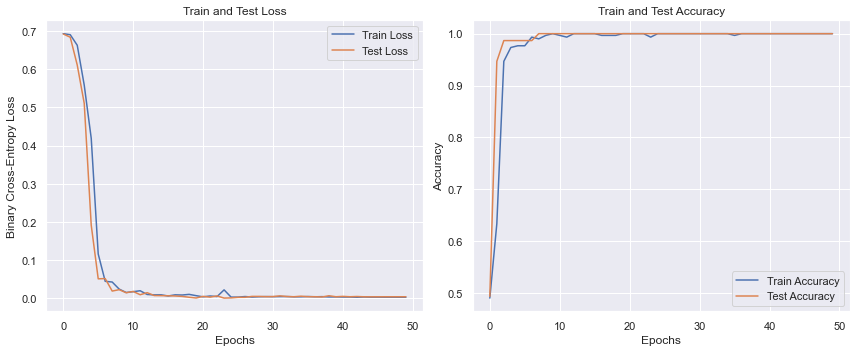

In [15]:
#Plot train/test loss and accuracy
hist = history.history

# Plot train and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['score_output_loss'], label='Train Loss')
plt.plot(hist['val_score_output_loss'], label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()

# Plot train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(hist['score_output_binary_accuracy'], label='Train Accuracy')
plt.plot(hist['val_score_output_binary_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluating model and visualising attention maps

In [16]:
#Loop through test images and store outputs
score_output = []  #Bag prediction probabilities
y_pred = []        #Predictions
h = []             #Features extracted by MLP
U = []             #Attention

for x, x_shape in zip(X_test, X_test_shapes):
    outputs = mil_model(x)
    p = np.squeeze(outputs[0].numpy())
    score_output.append(p)
    y_pred.append(np.round(p))
    h.append(np.reshape(outputs[1].numpy(), (x_shape[0], x_shape[1], -1)))
    U.append(np.reshape(outputs[2].numpy(), x_shape[:2]))

In [17]:
#Calculate some test set metrics
acc = accuracy_score(test_labels, y_pred)
auc = roc_auc_score(test_labels, score_output)
prec = precision_score(test_labels, y_pred)
rec = recall_score(test_labels, y_pred)

#Report metrics
print(f"Accuracy: {acc}.")
print(f"Area under ROC curve: {auc}.")
print(f"Precision: {prec}.")
print(f"Recall: {rec}. ")

Accuracy: 1.0.
Area under ROC curve: 1.0.
Precision: 1.0.
Recall: 1.0. 


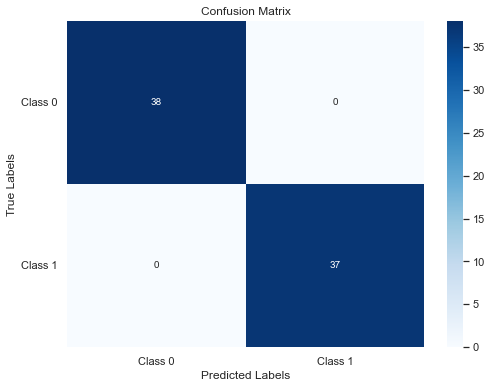

In [18]:
#Show the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.set_yticklabels(['Class 0', 'Class 1'], rotation=0)

plt.show()

Predicted probability: 0.9999769926071167.
True label: 1.


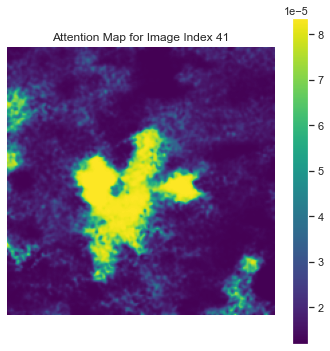

In [20]:
#Visualise a random (or specified) attention map alongside its prediction vs true label
img_ind = np.random.randint(0, len(test_labels))
# img_ind = 40

U_img = np.reshape(U[img_ind], X_test_shapes[img_ind][:2])

print(f"Predicted probability: {score_output[img_ind]}.")
print(f"True label: {test_labels[img_ind]}.")

#Show attention map with colorbar
plt.figure(figsize=(6, 6))
plt.imshow(U_img, cmap='viridis')
plt.axis('off')
plt.colorbar()
plt.title(f"Attention Map for Image Index {img_ind}")
plt.show()